<a href="https://colab.research.google.com/github/pablodamianr1983/BACK-APP/blob/main/copia_de_carry_trade_BDI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import requests
from datetime import date, timedelta
import matplotlib.pyplot as plt

In [ ]:
%%time

tickers = {
    "S16A5": date(2025, 4, 16),
    "S28A5": date(2025, 4, 28),
    "S16Y5": date(2025, 5, 16),
    "S30Y5": date(2025, 5, 30),
    "S18J5": date(2025, 6, 18),
    "S30J5": date(2025, 6, 30),
    "S31L5": date(2025, 7, 31),
    "S15G5": date(2025, 8, 15),
    "S29G5": date(2025, 8, 29),
    "S12S5": date(2025, 9, 12),
    "S30S5": date(2025, 9, 30),
    "T17O5": date(2025, 10, 15),
    "S31O5": date(2025, 10, 31),
    "S10N5": date(2025, 11, 10),
    "S28N5": date(2025, 11, 28),
    "T15D5": date(2025, 12, 15),
    "T30E6": date(2026, 1, 30),
    "T13F6": date(2026, 2, 13),
    "T30J6": date(2026, 6, 30),
    # "TO26":  date(2026, 10, 17),
    "T15E7": date(2027, 1, 15),
    "TTM26": date(2026, 3, 16),
    "TTJ26": date(2026, 6, 30),
    "TTS26": date(2026, 9, 15),
    "TTD26": date(2026, 12, 15),


}

payoff = {
    "S16A5": 131.211,
    "S28A5": 130.813,
    "S16Y5": 136.861,
    "S30Y5": 136.331,
    "S18J5": 147.695,
    "S30J5": 146.607,
    "S31L5": 147.74,
    "S15G5": 146.794,
    "S29G5": 157.7,
    "S12S5": 158.977,
    "S30S5": 159.734,
    "T17O5": 158.872,
    "S31O5": 132.821,
    "S10N5": 122.254,
    "S28N5": 123.561,
    "T15D5": 170.838,
    "T30E6": 142.222,
    "T13F6": 144.966,
    "T30J6": 144.896,
    # "TO26": 123.25, # Habria que calcular aparte la reinversion de cupones
    "T15E7": 160.777,
    "TTM26": 135.238,
    "TTJ26": 144.629,
    "TTS26": 152.096,
    "TTD26": 161.144,
}


# para los duales esta considerado solo la tasa fija, se puede agregar proyeccion de TAMAR c/API del BCRA

meps = requests.get('https://data912.com/live/mep').json()
notes = requests.get('https://data912.com/live/arg_notes').json()
bonds = requests.get('https://data912.com/live/arg_bonds').json()
mep = pd.DataFrame(meps).close.median()
df = pd.DataFrame(notes+bonds)

CPU times: user 67.6 ms, sys: 5.4 ms, total: 73 ms
Wall time: 2.92 s


In [ ]:
carry = df.loc[df.symbol.isin(tickers.keys())].set_index('symbol')
carry['bond_price'] = carry['c'].round(2)
carry['payoff'] = carry.index.map(payoff)
carry['expiration'] = carry.index.map(tickers)
carry['days_to_exp'] = (carry.expiration - date.today()).apply(lambda x: x.days)
carry['tna'] = ((carry['payoff'] / carry['c']) - 1) / carry['days_to_exp'] * 365
carry['tea'] = ((carry['payoff'] / carry['c'])) ** (365/carry['days_to_exp']) - 1
carry['tem'] = ((carry['payoff'] / carry['c'])) ** (1/(carry['days_to_exp']/30)) - 1
carry['tem_bid'] = ((carry['payoff'] / carry['px_bid'])) ** (1/(carry['days_to_exp']/30)) - 1
carry['tem_ask'] = ((carry['payoff'] / carry['px_ask'])) ** (1/(carry['days_to_exp']/30)) - 1
carry['finish_worst'] = (1400 * 1.01**(carry['days_to_exp']/30)).round().astype(int)
for price in [1000,1100, 1200, 1300,  1400]:
    carry[f'carry_{price}'] = (carry['payoff'] / carry['c']) * mep/price - 1
carry['carry_worst'] = (carry['payoff'] / carry['c']) * mep/carry['finish_worst'] - 1
carry = carry.sort_values('days_to_exp')

carry[['bond_price', 'days_to_exp'] + list(carry.columns[-7:])].style \
    .background_gradient(subset=carry.columns[-6:], cmap='Blues', axis=None) \
    .format({**{col: "{:.1%}" for col in carry.columns[-6:]}, 'bond_price': "{:.2f}"})

,bond_price,days_to_exp,finish_worst,carry_1000,carry_1100,carry_1200,carry_1300,carry_1400,carry_worst
symbol,,,,,,,,,
S28A5,130.14,7,1403,12.6%,2.4%,-6.2%,-13.4%,-19.6%,-19.7%
S16Y5,134.14,25,1412,14.3%,3.9%,-4.8%,-12.1%,-18.4%,-19.1%
S30Y5,132.04,39,1418,15.7%,5.1%,-3.6%,-11.0%,-17.4%,-18.4%
S18J5,140.75,58,1427,17.6%,6.9%,-2.0%,-9.6%,-16.0%,-17.6%
S30J5,138.75,70,1433,18.4%,7.6%,-1.4%,-8.9%,-15.5%,-17.4%
S31L5,136.00,101,1448,21.7%,10.6%,1.4%,-6.4%,-13.1%,-16.0%
S15G5,133.49,116,1455,23.2%,12.0%,2.7%,-5.2%,-12.0%,-15.3%
S29G5,142.00,130,1462,24.4%,13.1%,3.7%,-4.3%,-11.1%,-14.9%
S12S5,141.00,144,1468,26.3%,14.8%,5.3%,-2.8%,-9.8%,-14.0%


In [ ]:
vmax = carry[carry.columns[-6:]].max().max()
vmin = carry[carry.columns[-6:]].min().min()
lim = max(abs(vmin), abs(vmax)) * 0.3

carry[['bond_price', 'days_to_exp', 'tem'] + list(carry.columns[-7:])].style \
    .background_gradient(subset=carry.columns[-6:], cmap='RdYlGn', axis=None, vmin=-lim, vmax=lim) \
    .format({**{col: "{:.1%}" for col in carry.columns[-6:]}, 'bond_price': "{:.2f}", 'tem': "{:.2%}"})

,bond_price,days_to_exp,tem,finish_worst,carry_1000,carry_1100,carry_1200,carry_1300,carry_1400,carry_worst
symbol,,,,,,,,,,
S28A5,130.14,7,2.23%,1403,12.6%,2.4%,-6.2%,-13.4%,-19.6%,-19.7%
S16Y5,134.14,25,2.44%,1412,14.3%,3.9%,-4.8%,-12.1%,-18.4%,-19.1%
S30Y5,132.04,39,2.49%,1418,15.7%,5.1%,-3.6%,-11.0%,-17.4%,-18.4%
S18J5,140.75,58,2.52%,1427,17.6%,6.9%,-2.0%,-9.6%,-16.0%,-17.6%
S30J5,138.75,70,2.39%,1433,18.4%,7.6%,-1.4%,-8.9%,-15.5%,-17.4%
S31L5,136.00,101,2.49%,1448,21.7%,10.6%,1.4%,-6.4%,-13.1%,-16.0%
S15G5,133.49,116,2.49%,1455,23.2%,12.0%,2.7%,-5.2%,-12.0%,-15.3%
S29G5,142.00,130,2.45%,1462,24.4%,13.1%,3.7%,-4.3%,-11.1%,-14.9%
S12S5,141.00,144,2.53%,1468,26.3%,14.8%,5.3%,-2.8%,-9.8%,-14.0%


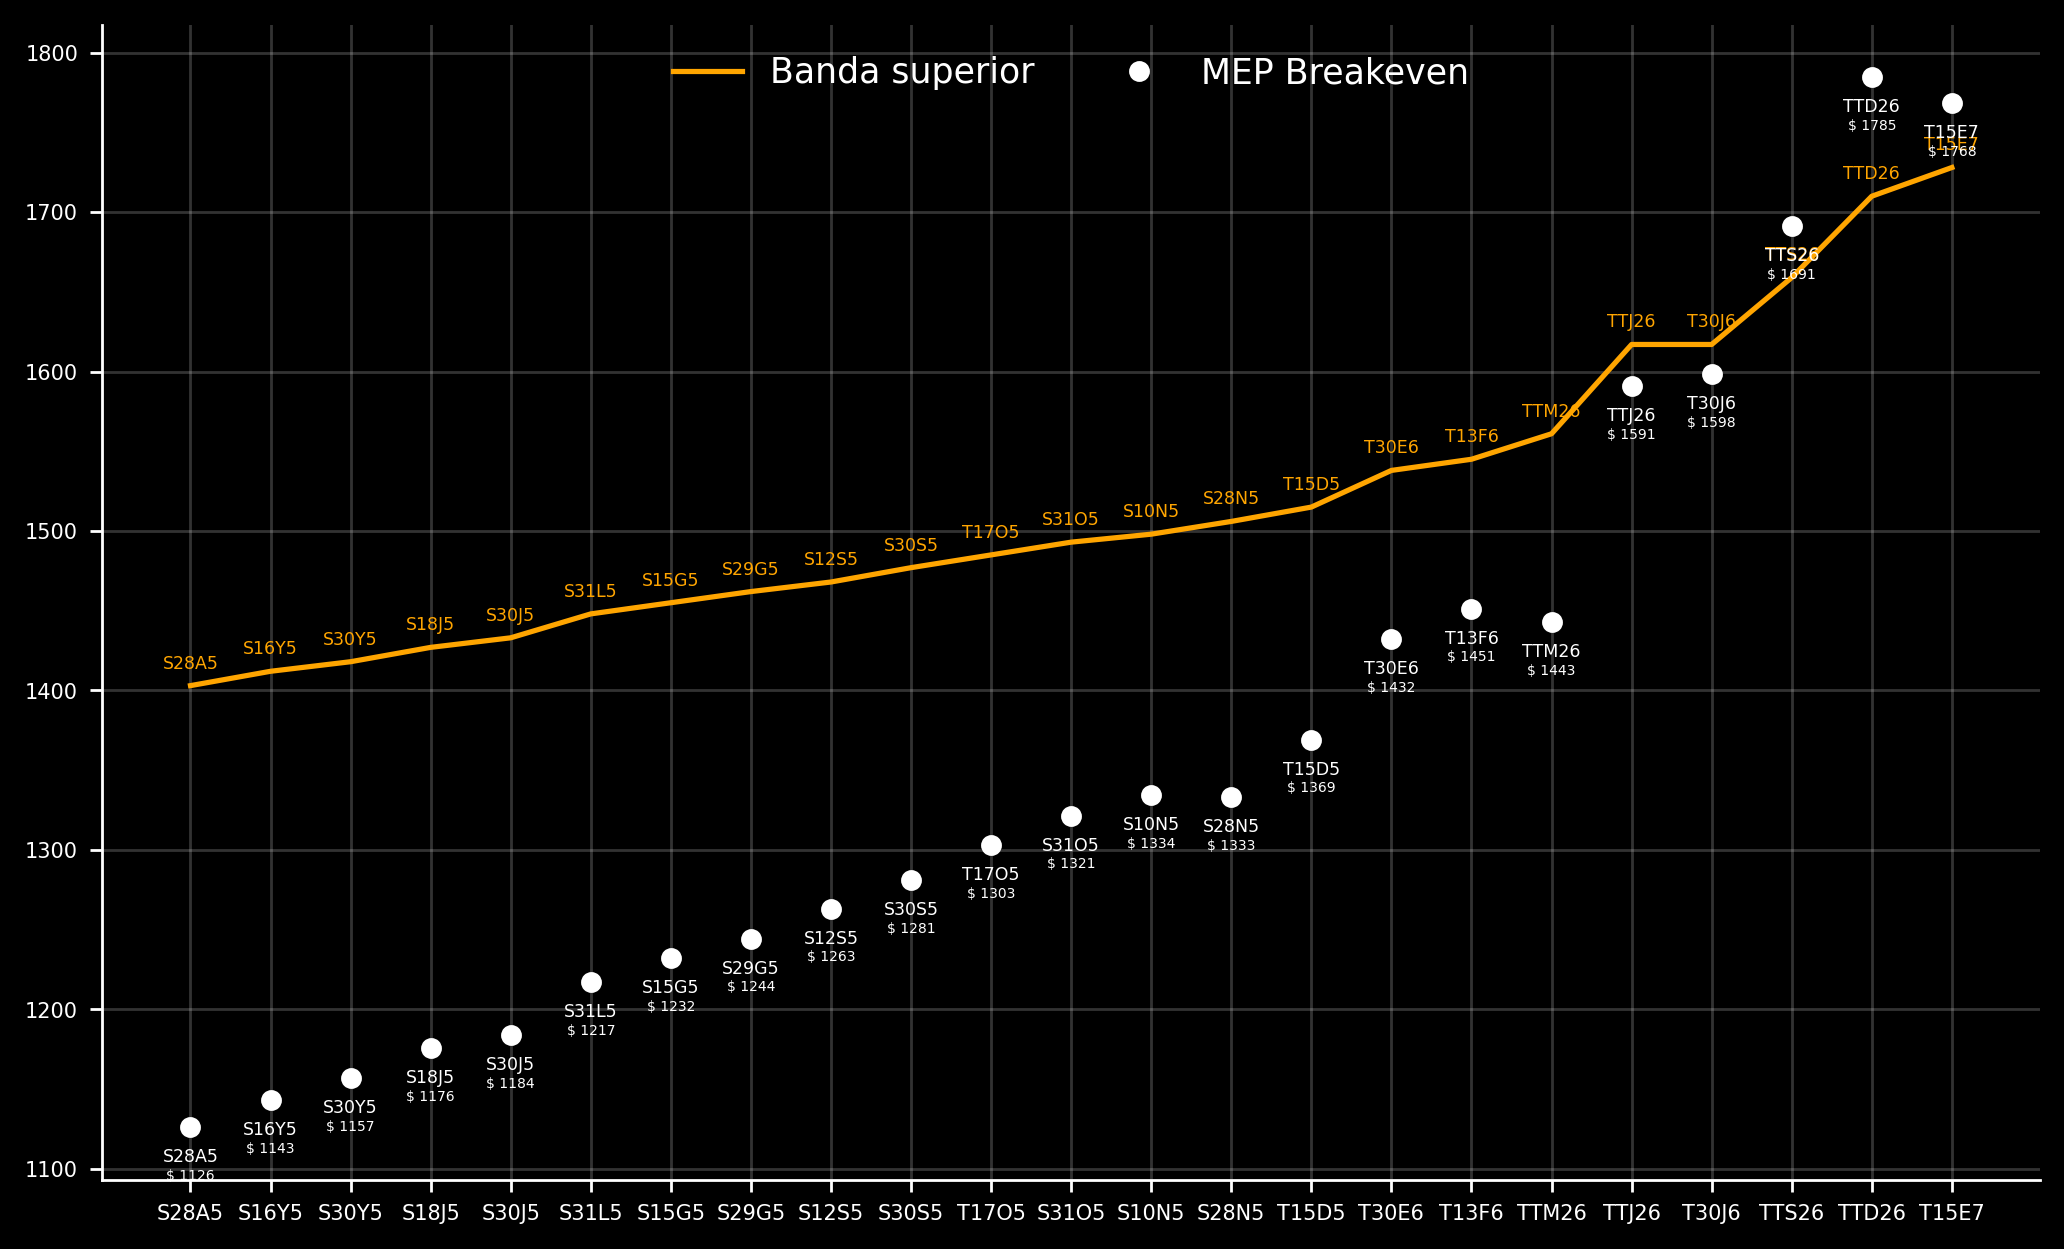

In [ ]:
carry['MEP_BREAKEVEN'] = mep * ((carry['payoff'] / carry['c']))

plt.style.use('dark_background')
plt.rcParams.update({'font.size': 6})

fig, ax = plt.subplots(figsize=(10,6), dpi=250, facecolor='black')

ax.plot(carry['finish_worst'], color='orange', label='Banda superior')
ax.plot(carry['MEP_BREAKEVEN'], color='white', lw=0, marker='o', markersize=5, label='MEP Breakeven')

for i, txt in enumerate(carry.index):
    y1 = carry['finish_worst'].iloc[i]
    y2 = carry['MEP_BREAKEVEN'].iloc[i]

    ax.annotate(txt, (i, y1), textcoords="offset points", xytext=(0, 5), ha='center', fontsize=5, color='orange')
    ax.annotate(txt, (i, y2), textcoords="offset points", xytext=(0, -10), ha='center', fontsize=5, color='white')
    ax.annotate(f'$ {y2:.0f}', (i, y2), textcoords="offset points", xytext=(0, -15), ha='center', fontsize=4, color='white')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(alpha=0.2)

ax.legend(frameon=False, ncol=2, fontsize=10, loc='upper center')
plt.show()

In [ ]:
# Simulacion rendimiento en pesos, estrategia de salida antes por compresion de tasa

CPI_EST = 0.01 # tasa estimada TEM general (Si todo sale bien esa tasa va a ir convergiendo a la de inflacion mensual)
EST_DATE = date(2025, 10, 15) # Fecha de salida con esa TEM (Fecha estimada pra desarmar)

carry_exit = df.loc[df.symbol.isin(tickers.keys())].set_index('symbol')
carry_exit['days_in'] = (EST_DATE - date.today()).days
carry_exit['payoff'] = carry_exit.index.map(payoff)
carry_exit['expiration'] = carry_exit.index.map(tickers)
carry_exit['days_to_exp'] = (carry_exit.expiration - EST_DATE).apply(lambda x: x.days)
carry_exit['exit_TEM'] = CPI_EST
carry_exit['bond_price_in'] = carry_exit['c']
carry_exit['bond_price_out'] = (carry_exit['payoff'] / ((1+CPI_EST)**(carry_exit['days_to_exp']/30))).round(2)
carry_exit['ars_direct_yield'] = carry_exit['bond_price_out'] / carry_exit['bond_price_in'] - 1
carry_exit['ars_tea'] = carry_exit['ars_direct_yield'].add(1).pow(1/(carry_exit['days_in']/365)).sub(1)
carry_exit = carry_exit.sort_values('days_to_exp').loc[carry_exit.days_to_exp>0]

print(f"Estrategia en ARS (Assumption de compresion de tasa) saliendo el: {EST_DATE} a una TEM promedio del {CPI_EST:.2%}")
carry_exit[['days_to_exp','exit_TEM', 'days_in', 'bond_price_in', 'bond_price_out',  'ars_direct_yield' , 'ars_tea']].style \
    .background_gradient(subset=carry_exit.columns[-2:], cmap='Blues', axis=None) \
    .format({**{col: "{:.1%}" for col in carry_exit.columns[-2:]}, 'bond_price_in': "{:.2f}",  'bond_price_out': "{:.2f}",
             'ars_direct_yield': "{:.0%}", 'ars_tea': "{:.0%}", 'exit_TEM': "{:.2%}"})

Estrategia en ARS (Assumption de compresion de tasa) saliendo el: 2025-10-15 a una TEM promedio del 1.00%


,days_to_exp,exit_TEM,days_in,bond_price_in,bond_price_out,ars_direct_yield,ars_tea
symbol,,,,,,,
S31O5,16,1.00%,177,112.62,132.12,17%,39%
S10N5,26,1.00%,177,102.65,121.20,18%,41%
S28N5,44,1.00%,177,103.84,121.77,17%,39%
T15D5,61,1.00%,177,139.80,167.42,20%,45%
T30E6,107,1.00%,177,111.25,137.26,23%,54%
T13F6,121,1.00%,177,111.90,139.26,24%,57%
TTM26,152,1.00%,177,105.00,128.59,22%,52%
TTJ26,258,1.00%,177,101.85,132.77,30%,73%
T30J6,258,1.00%,177,101.55,133.01,31%,74%


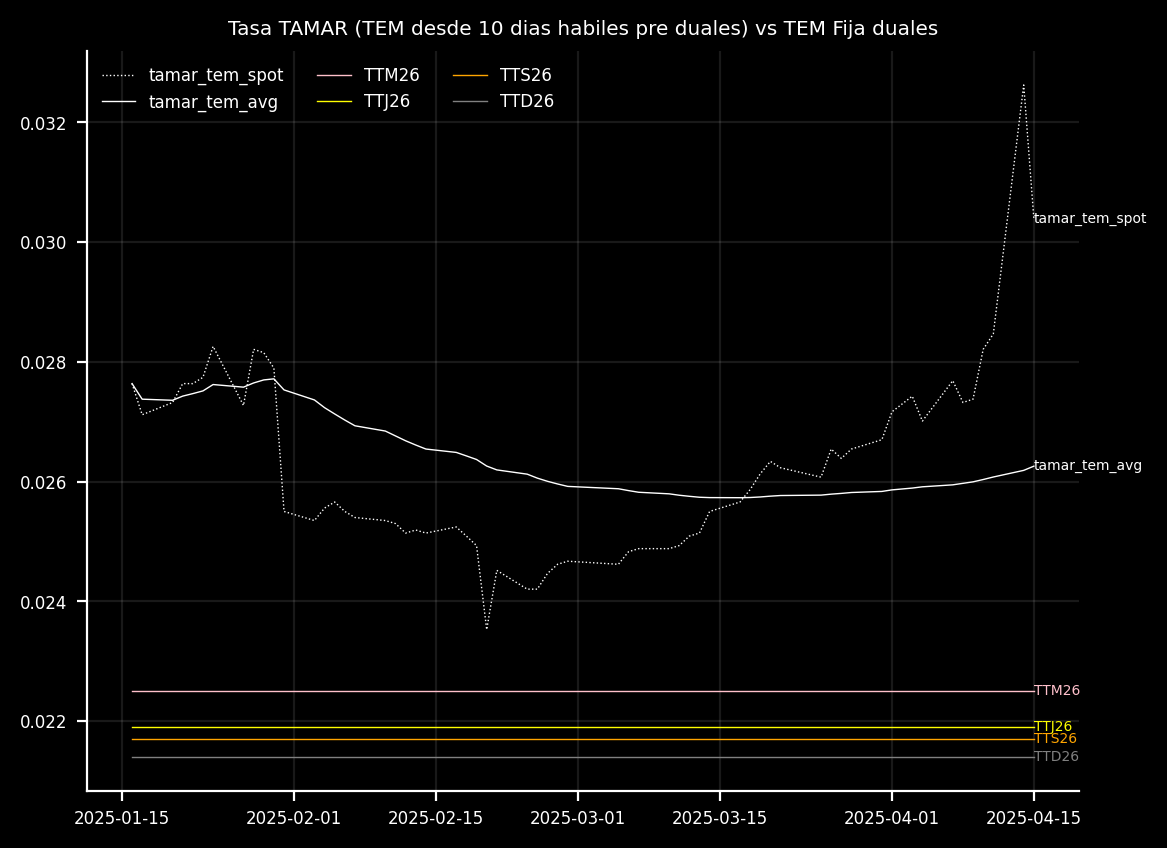

In [ ]:
import urllib3
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)
def getDataV3(variableID):
    url = f"https://api.bcra.gob.ar/estadisticas/v3.0/Monetarias/{variableID}"
    r = requests.get(url, verify=False)
    return pd.DataFrame(r.json().get('results')).set_index('fecha')

tamar_tea = getDataV3(variableID=45)['valor']/100
tamar_tea.index = pd.to_datetime(tamar_tea.index)
tamar_tea = tamar_tea.sort_index()
tamar_tea = tamar_tea.loc[tamar_tea.index>'2025-01-15']
tamar_tem = ((1+tamar_tea)**(1/12)-1).to_frame().rename(columns={'valor': 'tamar_tem_spot'})
tamar_tem['tamar_tem_avg'] = tamar_tem.expanding().mean()
tamar_tem['TTM26'] = 0.0225
tamar_tem['TTJ26'] = 0.0219
tamar_tem['TTS26'] = 0.0217
tamar_tem['TTD26'] = 0.0214


plt.style.use('dark_background')
plt.rcParams.update({'font.size': 6})

fig, ax = plt.subplots(dpi=200, facecolor='black')


colores = {
    'tamar_tem_spot': 'white',
    'tamar_tem_avg': 'white',
    'TTM26': 'pink',
    'TTJ26': 'yellow',
    'TTS26': 'orange',
    'TTD26': 'gray'
}

for col in tamar_tem.columns:
    y = tamar_tem[col].dropna()
    if not y.empty:
        estilo = ':' if col == 'tamar_tem_spot' else '-'
        ax.plot(y.index, y.values, lw=0.5, color=colores[col], linestyle=estilo, label=col)
        ax.text(y.index[-1], y.iloc[-1], col, fontsize=5, va='center', ha='left', color=colores[col])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(frameon=False, ncol=3)
ax.grid(alpha=0.1)

ax.set_title("Tasa TAMAR (TEM desde 10 dias habiles pre duales) vs TEM Fija duales")
plt.show()